In [ ]:
import pandas_datareader 
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

start= datetime.datetime(2012,1,1)
finish= datetime.datetime(2018,1,1)
%matplotlib inline

In [ ]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
sp500 = pd.read_csv('sp500.csv',parse_dates=True, index_col="Date",usecols=["Date", "Adj Close"], na_values=["nan"])

In [ ]:
sp500['Adj Close'].plot(figsize=(16,8), color='r', label='Sp500', title='Adjusted Close')


In [ ]:
sp500['Adj Close'].describe()

In [ ]:
### TIME SERIES ANALISYS TREND AND CYCLE STATMODELS

gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(sp500['Adj Close'],43200)# lamda for daily 43200  http://mycroft2b.com/trend-line-hodrick-prescott-filter/

sp500["trend"] = gdp_trend
sp500["cycle"] = gdp_cycle
print(sp500.head())
sp500[['trend','Adj Close']]["2017-01-03":].plot(figsize=(16,8))
plt.title("Trend Component SP500")


In [ ]:
sp500[['cycle']].plot(figsize=(16,8))
plt.title("CyCle Component SP500")

In [ ]:
### Exponential Weightied AVerage

#sp500["RM_5"] = sp500['Adj Close'].rolling(window=5).mean()
sp500["RM_21"] = sp500['Adj Close'].rolling(window=21).mean()
sp500["RM_63"] = sp500['Adj Close'].rolling(window=63).mean()

#sp500["EWMA_5"] = sp500['Adj Close'].ewm(span=5).mean()
sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=21).mean()
sp500["EWMA_63"] = sp500['Adj Close'].ewm(span=63).mean()


#sp500[["EWMA_5","EWMA_21","EWMA_63","RM_5","RM_21","RM_63",'Adj Close']]["2016-01-01":].plot(figsize=(12,6))
sp500[["EWMA_21","EWMA_63","RM_21","RM_63",'Adj Close']]["2016-01-01":].plot(figsize=(16,8))
plt.title("EWMA and Rolling Mean 21 & 63 Days SP500")

In [ ]:
### ETS-Decomposition
result = seasonal_decompose(sp500[['Adj Close']], model='multiplicative',freq=30)
picture=result.plot()
picture.set_size_inches(16,8)
picture.text(0.3,1,"ETS Decomposition Multiplicative model SP500")


In [ ]:
### ETS-Decomposition
result = seasonal_decompose(sp500[['Adj Close']], model='additive',freq=30)
picture=result.plot()
picture.set_size_inches(16,8)


In [ ]:
### ARIMA MODEL

sp500["RM_21"] = sp500['Adj Close'].rolling(window=21).mean()
sp500["RMS_21"] = sp500['Adj Close'].rolling(window=21).std()
sp500[["RMS_21","RM_21",'Adj Close']]["2016-01-01":].plot(figsize=(16,8))
plt.title("Rolling Mean & Rolling STD 21 Days SP500")

result = adf_check(sp500['Adj Close'])

In [ ]:
### ARIMA Diffrenciating


print("First Diff\n")
sp500['sp500 First Difference'] = sp500['Adj Close'] - sp500['Adj Close'].shift(1)
result = adf_check(sp500['sp500 First Difference'].dropna())

sp500['sp500 First Difference'].plot(figsize=(16,8))
plt.title("sp500 First Difference")

sp500['sp500 second Difference'] = sp500['sp500 First Difference'] - sp500['sp500 First Difference'].shift(1)
print("\nSecond Diff\n")
result = adf_check(sp500['sp500 second Difference'].dropna())
sp500[["sp500 First Difference", "sp500 second Difference"]].plot(figsize=(16,8),alpha=0.6)
plt.title("sp500 Second Difference")



In [ ]:
## Seaconality  lag of 254 observations = 1 year

sp500['sp500 seasonal'] =  sp500['Adj Close'] - sp500['Adj Close'].shift(254)
print("\n\nSeasonal 254 ADF TEST \n")
result = adf_check(sp500['sp500 seasonal'].dropna())
figure=sp500['sp500 seasonal'].plot(figsize=(16,8), label="Seasonal 254 Days")
#plt.savefig('sp500 seasonal 254 days.png')

sp500['sp500 seasonal 1Diff']= sp500['sp500 seasonal'] -sp500['sp500 seasonal'].shift(1)
print("\n\nSeasonal Different ADF Test \n")
result = adf_check(sp500['sp500 seasonal 1Diff'].dropna())

figure=sp500['sp500 seasonal 1Diff'].plot(figsize=(16,8),label="Seasonal Difference 1")
plt.legend()
#plt.savefig('sp500 seasonal 254 days 1 diff.png')


In [ ]:
#autocorrelation_plot(sp500['sp500 seasonal 1Diff'].dropna())

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sp500['sp500 seasonal 1Diff'].iloc[260:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sp500['sp500 seasonal 1Diff'].iloc[260:], lags=50, ax=ax2)

In [ ]:
help(ARIMA)

In [ ]:
model = sm.tsa.statespace.SARIMAX(sp500['Adj Close'],order=(1,1,1), seasonal_order=(0,1,0,4))
results = model.fit()
print(results.summary())

In [ ]:
results.resid.plot(figsize=(16,8))

In [ ]:
results.resid.plot(kind='kde',figsize=(16,8));

In [ ]:
sp500['forecast'] = results.predict(start='2016-12-29', dynamic= False)  
sp500['forecast'].tail()
sp500[['Adj Close','forecast']]["2016-01-01":].plot(figsize=(18,10))

In [ ]:
sp500['forecast'].tail()

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternatives 
# pd.date_range(df.index[-1],periods=12,freq='M')
from pandas.tseries.offsets import DateOffset

In [ ]:
sp500.index

In [ ]:
future_dates = [sp500.index[-1] + DateOffset(days=x) for x in range(0,180) ]

In [ ]:
future_dates

In [ ]:
start= datetime.datetime(2018,1,1)
finish= datetime.datetime(2018,6,30)
sp500_new = web.DataReader('^GSPC','yahoo',start,finish)

In [ ]:
sp500_new['Adj Close'].tail()

In [ ]:
sp500_new['Adj Close'].describe()

In [ ]:
future_dates_sp500 = pd.DataFrame(index=sp500_new.index,columns=sp500.columns)

In [ ]:
future_dates_sp500.tail()

In [ ]:
sp500.tail()

In [ ]:
colums=sp500.columns
print(colums)

In [ ]:
#sp500=sp500_seg.copy()

In [ ]:
sp500.tail()

In [ ]:
sp500_seg=sp500.copy()


In [ ]:
sp500_1=sp500.copy()
"""
ARIMA Model Seasonal, calculation done introducing as y_true new day to forecast the mean of the last 5 days.
we run model seanonal y acfter predit the value for today , we copy the real value  on the Adj Close
rmse =44.06175059256116
variance=r2= 0.9877451968398641

"""
y=0
for i in future_dates_sp500.index:
    offset= sp500.index[-1] - DateOffset(days=5)
    indice=sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['Adj Close'].mean()
    dates = pd.date_range(i,i)
    #print(indice)
    df = pd.DataFrame(data = {'Adj Close':sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['Adj Close'].mean(),'trend':0.0, 'cycle':0.0, 'RM_21':0.0, 'RM_63':0.0, 'EWMA_21':0.0, 'EWMA_63':0.0,'RMS_21':0.0, 'sp500 First Difference':0.0, 'sp500 second Difference':0.0,'sp500 seasonal':0.0, 'sp500 seasonal 1Diff':0.0, 'forecast':0.0}, index=dates)
    sp500=pd.concat([sp500,df])
    model = sm.tsa.statespace.SARIMAX(sp500['Adj Close'],order=(1,1,1), seasonal_order=(0,1,0,4), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    sp500['forecast'] =results.predict(start='2012-01-03', dynamic= False)
    x=sp500_new.loc[i:i]['Adj Close']
    sp500[i:i]=x
    y=y+1
    print ("round: {} || real: {} and forecast: {}".format(y,x,indice))
    
    

In [ ]:
print(results.summary())

In [ ]:
[sp500.loc["2017-12-29":,['Adj Close','forecast']]]

In [ ]:
sp500[['Adj Close','forecast']]["2017-12-01":].plot(figsize=(18,10))
sp500_new['Adj Close'].plot(label='Real',style='*',fontsize=8)
plt.legend()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
y_pred=sp500['forecast'].values

In [ ]:
y_true=sp500['Adj Close'].values

In [ ]:
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)

In [ ]:
print(rmse)

In [ ]:
print(r2)

In [ ]:
sp500=sp500_seg.copy()

In [ ]:
sp500_sec=sp500.copy()
"""
ARIMA Model Seasonal, calculation done introducing as y_true new day to forecast the mean of the last 3 days.
we run model seanonal y acfter predit the value for today , we copy the real value  on the Adj Close
rmse =44.06175059256116
variance=r2= 0.9877451968398641

same values than std 5 days
"""
y=0
for i in future_dates_sp500.index:
    offset= sp500.index[-1] - DateOffset(days=3)
    indice=sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['Adj Close'].mean()
    dates = pd.date_range(i,i)
    #print(indice)
    df = pd.DataFrame(data = {'Adj Close':sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['Adj Close'].mean(),'trend':0.0, 'cycle':0.0, 'RM_21':0.0, 'RM_63':0.0, 'EWMA_21':0.0, 'EWMA_63':0.0,'RMS_21':0.0, 'sp500 First Difference':0.0, 'sp500 second Difference':0.0,'sp500 seasonal':0.0, 'sp500 seasonal 1Diff':0.0, 'forecast':0.0}, index=dates)
    sp500=pd.concat([sp500,df])
    model = sm.tsa.statespace.SARIMAX(sp500['Adj Close'],order=(1,1,1), seasonal_order=(0,1,0,4), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    sp500['forecast'] =results.predict(start='2012-01-03', dynamic= False)
    x=sp500_new.loc[i:i]['Adj Close']
    sp500[i:i]=x
    y=y+1
    print ("round: {} || real: {} and forecast: {}".format(y,x,indice))

In [ ]:
print(results.summary())

In [ ]:
y_pred=sp500['forecast'].values
y_true=sp500['Adj Close'].values

In [ ]:
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)

In [ ]:
print(rmse)
print(r2)

In [ ]:
#airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12).mean()
#sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=21).mean()

In [175]:
sp500=sp500_seg.copy()


In [177]:
sp500.tail(22)

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff,forecast
Date,,,,,,,,,,,,,
2017-11-29,2626.070068,2625.752715,0.317353,2590.161923,2546.040492,2590.524816,2550.646873,15.224673,-0.969971,-26.590088,412.719970,-9.600098,2618.195985
2017-11-30,2647.580078,2628.689336,18.890742,2593.605736,2548.833035,2595.711658,2553.676035,19.315194,21.510010,22.479981,445.860107,33.140137,2624.244138
2017-12-01,2642.219971,2631.644898,10.575073,2596.599063,2551.462716,2599.939686,2556.443033,21.718402,-5.360107,-26.870117,437.560059,-8.300048,2634.856055
2017-12-04,2639.439941,2634.617565,4.822376,2599.436675,2554.345095,2603.530618,2559.036687,23.258869,-2.780030,2.580077,440.629882,3.069823,2657.354814
2017-12-05,2629.570068,2637.605745,-8.035677,2601.423817,2556.948746,2605.897841,2561.240855,23.989703,-9.869873,-7.089843,438.489990,-2.139892,2636.006838
2017-12-06,2629.270020,2640.607955,-11.337935,2603.240014,2559.554618,2608.022585,2563.366766,24.607208,-0.300048,9.569825,437.320069,-1.169921,2651.130307
2017-12-07,2636.979980,2643.622531,-6.642551,2605.446684,2562.341126,2610.655075,2565.667179,25.482993,7.709960,8.010008,432.270019,-5.050050,2630.115080
2017-12-08,2651.500000,2646.647542,4.852458,2608.166690,2564.934617,2614.368250,2568.349455,27.231163,14.520020,6.810060,439.270020,7.000001,2636.712253
2017-12-11,2659.989990,2649.680907,10.309083,2611.755731,2567.530014,2618.515681,2571.213222,28.888954,8.489990,-6.030030,418.639892,-20.630128,2639.258429


In [178]:
sp500_sec=sp500.copy()
"""
ARIMA Model Seasonal, calculation done introducing as y_true new day to forecast the mean of the last 3 days EWMA.
we run model seanonal y acfter predit the value for today , we copy the real value  on the Adj Close
rmse =44.05714812255738
variance=r2= 0.9877477568569961


same values than std 5 days
"""
y=0
for i in future_dates_sp500.index:
    offset= sp500.index[-1] - DateOffset(days=3)
    indice=sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['EWMA_21'].mean()
    dates = pd.date_range(i,i)
    #print(indice)
    df = pd.DataFrame(data = {'Adj Close':sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['EWMA_21'].mean(),'trend':0.0, 'cycle':0.0, 'RM_21':0.0, 'RM_63':0.0, 'EWMA_21':0.0, 'EWMA_63':0.0,'RMS_21':0.0, 'sp500 First Difference':0.0, 'sp500 second Difference':0.0,'sp500 seasonal':0.0, 'sp500 seasonal 1Diff':0.0, 'forecast':0.0}, index=dates)
    sp500=pd.concat([sp500,df])
    model = sm.tsa.statespace.SARIMAX(sp500['Adj Close'],order=(1,1,1), seasonal_order=(0,1,0,4), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    sp500['forecast'] =results.predict(start='2012-01-03', dynamic= False)
    x=sp500_new.loc[i:i]['Adj Close']
    sp500[i:i]=x
    y=y+1
    print ("round: {} || real: {} and forecast: {}".format(y,x,indice))
    sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=10).mean()

round: 1 || real: Date
2018-01-02    2695.810059
Name: Adj Close, dtype: float64 and forecast: 2658.301659172576
round: 2 || real: Date
2018-01-03    2713.060059
Name: Adj Close, dtype: float64 and forecast: 2680.1359881769686
round: 3 || real: Date
2018-01-04    2723.98999
Name: Adj Close, dtype: float64 and forecast: 2683.129085524517
round: 4 || real: Date
2018-01-05    2743.149902
Name: Adj Close, dtype: float64 and forecast: 2686.4218032541808
round: 5 || real: Date
2018-01-08    2747.709961
Name: Adj Close, dtype: float64 and forecast: 2690.34737408658
round: 6 || real: Date
2018-01-09    2751.290039
Name: Adj Close, dtype: float64 and forecast: 2706.2682569852536
round: 7 || real: Date
2018-01-10    2748.22998
Name: Adj Close, dtype: float64 and forecast: 2714.1285738970255
round: 8 || real: Date
2018-01-11    2767.560059
Name: Adj Close, dtype: float64 and forecast: 2717.2088202848627
round: 9 || real: Date
2018-01-12    2786.23999
Name: Adj Close, dtype: float64 and forecast: 

round: 73 || real: Date
2018-04-17    2706.389893
Name: Adj Close, dtype: float64 and forecast: 2648.016394280914
round: 74 || real: Date
2018-04-18    2708.639893
Name: Adj Close, dtype: float64 and forecast: 2656.0343208662016
round: 75 || real: Date
2018-04-19    2693.129883
Name: Adj Close, dtype: float64 and forecast: 2660.595871144626
round: 76 || real: Date
2018-04-20    2670.139893
Name: Adj Close, dtype: float64 and forecast: 2663.94077861559
round: 77 || real: Date
2018-04-23    2670.290039
Name: Adj Close, dtype: float64 and forecast: 2669.510617140028
round: 78 || real: Date
2018-04-24    2634.560059
Name: Adj Close, dtype: float64 and forecast: 2673.006474227795
round: 79 || real: Date
2018-04-25    2639.399902
Name: Adj Close, dtype: float64 and forecast: 2669.2643969136507
round: 80 || real: Date
2018-04-26    2666.939941
Name: Adj Close, dtype: float64 and forecast: 2666.507945581845
round: 81 || real: Date
2018-04-27    2669.909912
Name: Adj Close, dtype: float64 and f

In [179]:
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                         Adj Close   No. Observations:                 1634
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 4)   Log Likelihood               -7267.585
Date:                           Wed, 04 Jul 2018   AIC                          14541.170
Time:                                   21:46:36   BIC                          14557.367
Sample:                               01-03-2012   HQIC                         14547.178
                                    - 06-29-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7279      0.013    -57.700      0.000      -0.753      -0.703
ma.L1          1.0000      2.008      0.498

In [180]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred=sp500['forecast'].values
y_true=sp500['Adj Close'].values

In [181]:
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)

In [182]:
print(rmse)
print(r2)

44.05714812255738
0.9877477568569961


In [183]:
import numpy as np
plt.figure()
sp500['Upper band']=sp500['forecast'].apply(lambda x: x + (2*rmse))
sp500['Lower band']=sp500['forecast'].apply(lambda x: x -(2*rmse))
#sp500[['Adj Close','forecast','Upper band','Lower band']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
#plt.plot(price.index, price, 'k')
indexs=sp500[['Adj Close']]["2017-12-01":]
sp500a=sp500[['Adj Close']]["2017-12-01":].values
forea=sp500[['forecast']]["2017-12-01":].values
upper=np.array([sp500[['Upper band']]["2017-12-01":].values]).reshape(145,)
lower=np.array([sp500[['Lower band']]["2017-12-01":].values]).reshape(145,)
print(upper)


[2748.32452143 2741.14981728 2733.66933044 2729.69809188 2715.59350383
 2722.29538354 2734.45959821 2748.07625897 2760.86244044 2762.12193112
 2745.09015004 2775.72241138 2772.11841559 2761.61971697 2790.63080153
 2782.55069794 2763.01555435 2767.73142934 2775.8964643  2774.47363987
 2755.38741592 2796.33666205 2799.91623408 2805.97983897 2854.64677769
 2847.10368469 2852.58988412 2849.45216683 2866.32862876 2875.67734564
 2860.09189958 2919.31288018 2889.04453698 2902.62346391 2942.02469445
 2922.48628646 2938.95025903 2946.14217832 2974.00653622 2926.27409649
 2918.01414571 2939.69874993 2886.97209905 2811.92606392 2723.3619262
 2808.65438583 2679.54891032 2575.20062357 2775.79520799 2706.07076135
 2680.48551463 2832.23927654 2847.20020714 2826.21398208 2834.9068274
 2813.42600323 2793.54883206 2830.48940055 2854.85850554 2827.41586959
 2843.90714306 2777.8774142  2759.15577387 2781.15193318 2787.74439261
 2830.28792783 2854.59901881 2888.90074617 2859.86942854 2871.08299628
 2872.10

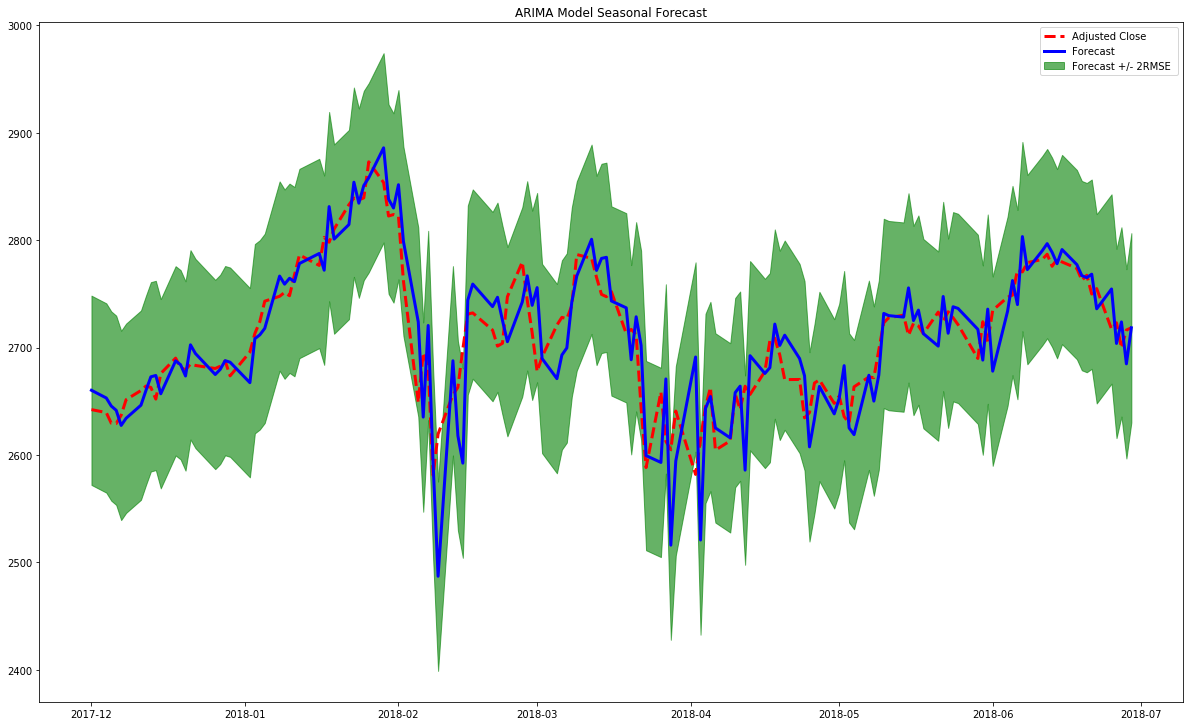

In [184]:
fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)
fig.set_size_inches(20.5, 12.5, forward=True)
#sp500[['Adj Close']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
plt.plot(indexs.index, sp500a,linewidth=3,color='r', label='Adjusted Close', linestyle='dashed')
plt.plot(indexs.index, forea,linewidth=3, label='Forecast', color='b', linestyle='-')
plt.fill_between(indexs.index, upper,lower, color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
#plt.plot(upper,linewidth=2, label='Upper Band', color='g', linestyle=':')
#plt.plot(lower,linewidth=2, label='Lower band', color='g', linestyle=':')
#sp500[['forecast']]["2017-12-01":].plot(style='*',fontsize=8,label='Forecast', Color='b')
#sp500[['Upper band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')
#sp500[['Lower band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')

#sp500_new['Adj Close'].plot(label='Real',style='*',fontsize=8)
plt.title('ARIMA Model Seasonal Forecast')
plt.legend()
plt.savefig('Prediction.png')
plt.show()

In [185]:
sp500=sp500_seg.copy()

In [186]:
sp500.tail()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff,forecast
Date,,,,,,,,,,,,,
2017-12-22,2683.340088,2677.100141,6.239947,2650.812872,2592.309539,2652.134103,2597.144291,26.273759,-1.229980,-6.550048,412.580078,-9.459961,2697.510959
2017-12-26,2680.500000,2680.143553,0.356447,2654.530971,2595.224776,2654.712821,2599.749157,24.551321,-2.840088,-1.610108,415.320068,2.739990,2677.639005
2017-12-27,2682.620117,2683.185925,-0.565808,2658.397647,2598.011761,2657.249848,2602.338874,22.033598,2.120117,4.960205,421.660156,6.340088,2679.615885
2017-12-28,2687.540039,2686.227603,1.312436,2661.278599,2600.828904,2660.003502,2605.001410,21.680949,4.919922,2.799805,423.750000,2.089844,2688.050272
2017-12-29,2673.610107,2689.268918,-15.658811,2663.542411,2603.277317,2661.240466,2607.145432,20.255955,-13.929932,-18.849854,404.730224,-19.019776,2686.532996


In [188]:
sp500_sec=sp500.copy()
"""
ARIMA Model Seasonal, calculation done introducing as y_true new day to forecast the mean of the last 3 days EWMA.
we run model seanonal y acfter predit the value for today , we copy the real value  on the Adj Close
rmse =
variance=r2= 

44.05714812255738
0.9877477568569961

44.058542717873365
0.9877469811739543

same values than std 5 days
"""
y=0
for i in future_dates_sp500.index:
    offset= sp500.index[-1] - DateOffset(days=3)
    indice=sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['EWMA_21'].mean()
    dates = pd.date_range(i,i)
    #print(indice)
    df = pd.DataFrame(data = {'Adj Close':sp500.loc[sp500.index[-1]]['EWMA_21'],'trend':0.0, 'cycle':0.0, 'RM_21':0.0, 'RM_63':0.0, 'EWMA_21':0.0, 'EWMA_63':0.0,'RMS_21':0.0, 'sp500 First Difference':0.0, 'sp500 second Difference':0.0,'sp500 seasonal':0.0, 'sp500 seasonal 1Diff':0.0, 'forecast':0.0}, index=dates)
    sp500=pd.concat([sp500,df])
    model = sm.tsa.statespace.SARIMAX(sp500['Adj Close'],order=(1,1,1), seasonal_order=(0,1,0,4), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    sp500['forecast'] =results.predict(start='2012-01-03', dynamic= False)
    x=sp500_new.loc[i:i]['Adj Close']
    sp500[i:i]=x
    y=y+1
    print ("round: {} || real: {} and forecast: {}".format(y,x,indice))
    sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=10).mean()

round: 1 || real: Date
2018-01-02    2695.810059
Name: Adj Close, dtype: float64 and forecast: 2658.301659172576
round: 2 || real: Date
2018-01-03    2713.060059
Name: Adj Close, dtype: float64 and forecast: 2680.1359881769686
round: 3 || real: Date
2018-01-04    2723.98999
Name: Adj Close, dtype: float64 and forecast: 2683.129085524517
round: 4 || real: Date
2018-01-05    2743.149902
Name: Adj Close, dtype: float64 and forecast: 2686.4218032541808
round: 5 || real: Date
2018-01-08    2747.709961
Name: Adj Close, dtype: float64 and forecast: 2690.34737408658
round: 6 || real: Date
2018-01-09    2751.290039
Name: Adj Close, dtype: float64 and forecast: 2706.2682569852536
round: 7 || real: Date
2018-01-10    2748.22998
Name: Adj Close, dtype: float64 and forecast: 2714.1285738970255
round: 8 || real: Date
2018-01-11    2767.560059
Name: Adj Close, dtype: float64 and forecast: 2717.2088202848627
round: 9 || real: Date
2018-01-12    2786.23999
Name: Adj Close, dtype: float64 and forecast: 

j:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


round: 25 || real: Date
2018-02-06    2695.139893
Name: Adj Close, dtype: float64 and forecast: 2798.4233612123344
round: 26 || real: Date
2018-02-07    2681.659912
Name: Adj Close, dtype: float64 and forecast: 2775.444553173728
round: 27 || real: Date
2018-02-08    2581.0
Name: Adj Close, dtype: float64 and forecast: 2767.570508431188
round: 28 || real: Date
2018-02-09    2619.550049
Name: Adj Close, dtype: float64 and forecast: 2755.8688306532767
round: 29 || real: Date
2018-02-12    2656.0
Name: Adj Close, dtype: float64 and forecast: 2735.5904002617717
round: 30 || real: Date
2018-02-13    2662.939941
Name: Adj Close, dtype: float64 and forecast: 2698.1466342046187
round: 31 || real: Date
2018-02-14    2698.629883
Name: Adj Close, dtype: float64 and forecast: 2691.1145135310517
round: 32 || real: Date
2018-02-15    2731.199951
Name: Adj Close, dtype: float64 and forecast: 2690.8015930358983
round: 33 || real: Date
2018-02-16    2732.219971
Name: Adj Close, dtype: float64 and foreca

round: 97 || real: Date
2018-05-21    2733.01001
Name: Adj Close, dtype: float64 and forecast: 2702.6242238657837
round: 98 || real: Date
2018-05-22    2724.439941
Name: Adj Close, dtype: float64 and forecast: 2708.929224783219
round: 99 || real: Date
2018-05-23    2733.290039
Name: Adj Close, dtype: float64 and forecast: 2712.5284521862704
round: 100 || real: Date
2018-05-24    2727.76001
Name: Adj Close, dtype: float64 and forecast: 2714.1115889608104
round: 101 || real: Date
2018-05-25    2721.330078
Name: Adj Close, dtype: float64 and forecast: 2715.3796185976307
round: 102 || real: Date
2018-05-29    2689.860107
Name: Adj Close, dtype: float64 and forecast: 2717.438781943516
round: 103 || real: Date
2018-05-30    2724.01001
Name: Adj Close, dtype: float64 and forecast: 2714.171438563268
round: 104 || real: Date
2018-05-31    2705.27002
Name: Adj Close, dtype: float64 and forecast: 2715.0658541484254
round: 105 || real: Date
2018-06-01    2734.620117
Name: Adj Close, dtype: float64

In [189]:
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                         Adj Close   No. Observations:                 1634
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 4)   Log Likelihood               -7266.781
Date:                           Wed, 04 Jul 2018   AIC                          14539.562
Time:                                   21:51:58   BIC                          14555.758
Sample:                               01-03-2012   HQIC                         14545.570
                                    - 06-29-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7284      0.013    -57.742      0.000      -0.753      -0.704
ma.L1          1.0000      0.509      1.966

In [190]:
y_pred=sp500['forecast'].values
y_true=sp500['Adj Close'].values
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)
print(rmse)
print(r2)

44.058542717873365
0.9877469811739543


In [191]:
plt.figure()
sp500['Upper band']=sp500['forecast'].apply(lambda x: x + (2*rmse))
sp500['Lower band']=sp500['forecast'].apply(lambda x: x -(2*rmse))
#sp500[['Adj Close','forecast','Upper band','Lower band']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
#plt.plot(price.index, price, 'k')
indexs=sp500[['Adj Close']]["2017-12-01":]
sp500a=sp500[['Adj Close']]["2017-12-01":].values
forea=sp500[['forecast']]["2017-12-01":].values
upper=np.array([sp500[['Upper band']]["2017-12-01":].values]).reshape(len(sp500a),)
lower=np.array([sp500[['Lower band']]["2017-12-01":].values]).reshape(len(sp500a),)
print(upper)

[2748.30124897 2741.1809147  2733.65857688 2729.71903602 2715.58947491
 2722.29819976 2734.45337745 2748.07851887 2760.86346342 2762.13114296
 2745.09968893 2775.71050568 2772.13057821 2761.61699688 2790.63462041
 2782.56205374 2763.01787232 2767.73165194 2775.89956482 2774.4763257
 2755.39690277 2796.31975608 2799.93084936 2805.96768917 2854.64731435
 2847.11788435 2852.58836835 2849.46652238 2866.3197708  2875.68444269
 2860.09734168 2919.29785615 2889.07751698 2902.59941031 2942.03743868
 2922.48950173 2938.95109574 2946.15240197 2973.99620997 2926.30323333
 2918.0059274  2939.71271073 2886.98213119 2811.94264945 2723.39355269
 2808.60508395 2679.60980602 2575.16653409 2775.75606185 2706.12052143
 2680.43076032 2832.22877321 2847.21938537 2826.21878959 2834.91949022
 2813.44520924 2793.55076127 2830.4710747  2854.85733746 2827.43320099
 2843.9125759  2777.91884152 2759.12966992 2781.14984093 2787.73252088
 2830.28727804 2854.605977   2888.89006926 2859.89124685 2871.07527884
 2872.1

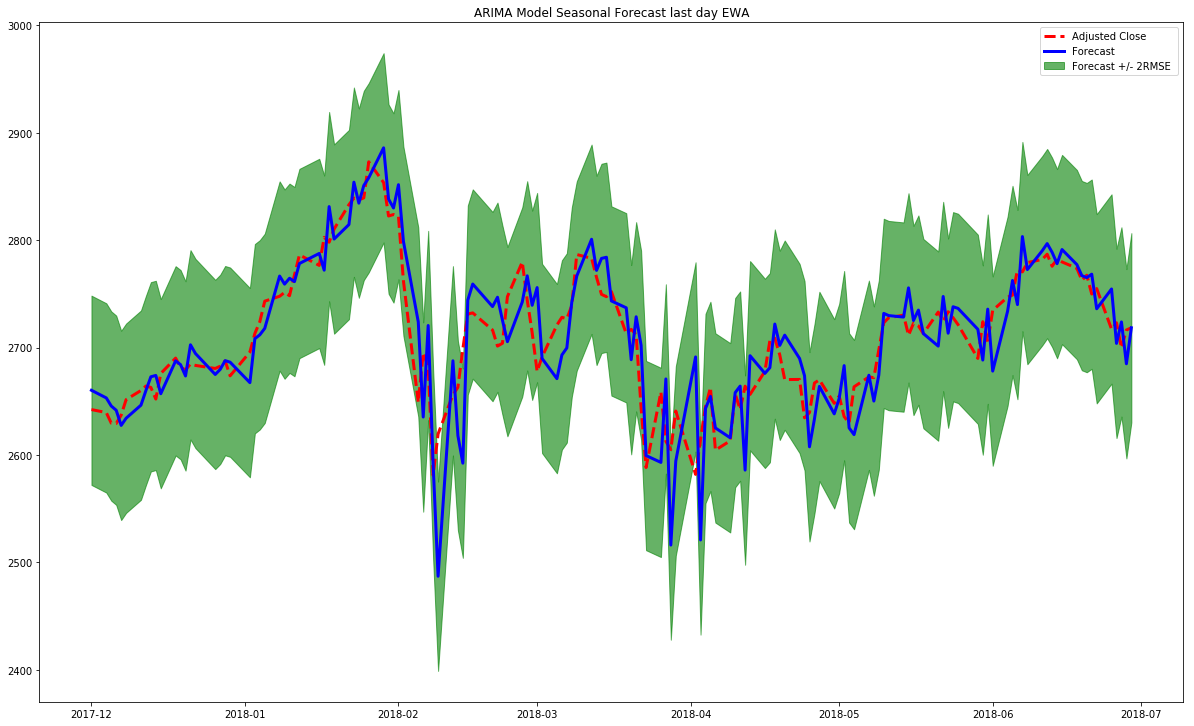

In [192]:
fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)
fig.set_size_inches(20.5, 12.5, forward=True)
#sp500[['Adj Close']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
plt.plot(indexs.index, sp500a,linewidth=3,color='r', label='Adjusted Close', linestyle='dashed')
plt.plot(indexs.index, forea,linewidth=3, label='Forecast', color='b', linestyle='-')
plt.fill_between(indexs.index, upper,lower, color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
#plt.plot(upper,linewidth=2, label='Upper Band', color='g', linestyle=':')
#plt.plot(lower,linewidth=2, label='Lower band', color='g', linestyle=':')
#sp500[['forecast']]["2017-12-01":].plot(style='*',fontsize=8,label='Forecast', Color='b')
#sp500[['Upper band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')
#sp500[['Lower band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')

#sp500_new['Adj Close'].plot(label='Real',style='*',fontsize=8)
plt.title('ARIMA Model Seasonal Forecast last day EWA')
plt.legend()
plt.savefig('Prediction_2.png')
plt.show()